In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sy
import scipy.stats as ss
import pandas as pd
from scipy.signal import savgol_filter
import string
from scipy.signal import find_peaks
import os
import statistics

from functions.plotting_tools import set_layout
from functions.plotting_tools import save_figures
from functions.plotting_tools import plot_vertical_line
from functions.plotting_tools import change_width
from functions.statistical_analysis import find_peaks_distribution

In [3]:
def convergence_threshold(FractDim, atoms):
    thresh=None
    std=np.std(FractDim)
    for t in range(len(FractDim)):
        if (FractDim[t]<np.mean(FractDim)-std):
            thresh=atoms[t]
    return thresh


## CUMULATIVE TRACE ANALYSIS: ENTANGLED FRACTION AND FRACTAL DIMENSION

In this notebook we analyze the data produced by cumulative analysis (CTforCumulativeAnalysis.py). Specifically we analyze:
- Entangled fraction: local maxima can be detected along the cumulative trace of entangled fraction. We calculate the distance between these local peaks and look at the distribution of these distances for a whole cell. The distributions all peak at about 10-12 Mb.
- Fractal dimension: the cumulative trace of fractal dimension converges to a constant value after a certain 'threshold' in number of atoms. We track this threshold and we demonstrate that the threshold for high clustering  is lower than that for low clustering cells

## 1. ENTANGLED FRACTION

Load data of the cell you want to analyze

In [36]:
path ='data/cumulative analysis traces/cell8'
files = os.listdir(path)
files_xls = [f for f in files if f[-3:] == 'xls']
n_all_chr=len(files_xls)
letters=list(string.ascii_lowercase)
chr_vec=['chr {}'.format(letter) for letter in letters[:n_all_chr]]
cell=path[-5:]
path_results = 'results/cumulative analysis/{}'.format(cell)
set_layout()

Plot entangled fraction traces and find local maxima

In [37]:
save_fig= False
plot_fig= False
window=15
polynomial=2
distance_allchr=[]
sel_threshold=0
sel_prominence=0.2


for t in range(len(files_xls)):
    xls=pd.ExcelFile('{}/{}'.format(path,files_xls[t]))
    df = pd.read_excel(xls)
    atoms=df['n atoms']
    series=df['Series']
    filt_series=savgol_filter(series, window,polynomial)
    fract_ent=np.copy(100-filt_series)
    peak= find_peaks(fract_ent, threshold=sel_threshold, prominence=sel_prominence)
    array=np.array(peak[0])
    
    dist=np.zeros(len(array)-1)
    for m in range(len(dist)):
        dist[m]=atoms[array[m+1]]-atoms[array[m]]
        
    for j in range(len(dist)):
        distance_allchr.append(dist[j])    
       
    if plot_fig:
        letter=chr_vec[t][-1:]
        fig = plt.figure()
        plt.plot(atoms, fract_ent, color='m', label='Filtered entangled fraction')
        plt.scatter(atoms[array],fract_ent[array], label='Local maxima')
        string_title='Chromosome {}'.format(letter)
        plt.title(string_title.upper())
        plt.xlabel('number of particles (100 kb)')
        plt.ylabel('Entagled fraction (%)')    
        plt.xlim(20,atoms[len(atoms)-1])
        plt.legend()
        
        if save_fig:
            save_figures(fig,path_results, name_file = 'Chromosome {}'.format(letter))

Plot distribution distance between peaks, save distribution stats

[ 99.28776792 759.47719739]


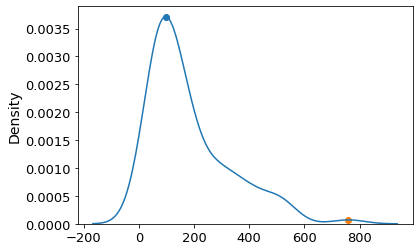

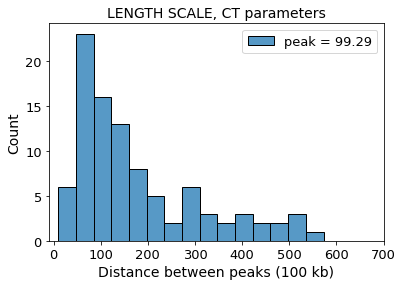

In [38]:
plot_fig= True
save_data= True

x, peaks= find_peaks_distribution(distance_allchr,1)
max_dist=x[peaks]
print(max_dist)

#Retrieve values of the distribution
max_dist=max_dist[0]
mean_dist=np.mean(distance_allchr)
median_dist=statistics.median(distance_allchr)

try:
    mode_dist=statistics.mode(distance_allchr)
except:
    print('mode distribution failes')
    mode_dist= 'NaN'
    
std_dist=np.std(distance_allchr)

if plot_fig:
    fig = plt.figure()
    peak="%.2f" % round(max_dist, 2)
    sns.histplot(distance_allchr, kde=False, bins=20, label='peak = {}'.format(peak))
    plt.xlim(-10,700)
    plt.xlabel('Distance between peaks (100 kb)')
    plt.legend()
    plt.title('LENGTH SCALE, CT parameters')
    
if save_data:
    stats= {'Peak': [max_dist], 'Mean':[mean_dist], 'Std dev': [std_dist],'Median': [median_dist],
            'Mode': [mode_dist]}
    stats_df=pd.DataFrame(stats)
    stats_df.to_csv('{}/Distribution_distancePeaks.csv'.format(path_results))


Plot barplot of distribution peaks, for high and low clustering cells

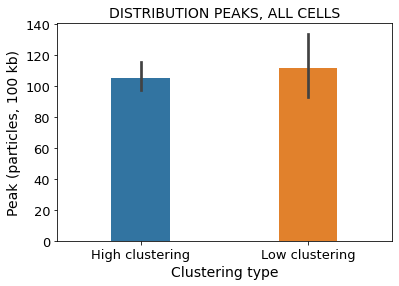

In [45]:
save_fig=True
peaks_allcells=pd.DataFrame()

for cell in cells:
    Peaks = pd.read_csv('results/cumulative analysis/{}/Distribution_distancePeaks.csv'.format(cell))
    if cell in high_clust:
        Peaks['Clustering']= ['High clustering']
    else:
        Peaks['Clustering']= ['Low clustering']
    frames=[peaks_allcells, Peaks]
    peaks_allcells=pd.concat(frames)
    
fig, ax = plt.subplots()
sns.barplot(x='Clustering', y='Peak', data=peaks_allcells, ax=ax)
change_width(ax, .35)
plt.xlabel('Clustering type')
plt.ylabel('Peak (particles, 100 kb)')
plt.title('DISTRIBUTION PEAKS, ALL CELLS')

if save_fig:
    save_figures(fig, path='results/cumulative analysis', name_file='peaks_allcells')

In [40]:
Peaks

,Unnamed: 0,Peak,Mean,Std dev,Median,Mode
0,0,99.287768,181.5625,146.23453,130.0,60.0


## FRACTAL DIMENSION CONVERGENCE

Load data from the cell you want to analyze. Choose chromosome you want to analyze.

In [5]:
path ='data/cumulative analysis traces/cell8'
files = os.listdir(path)
files_xls = [f for f in files if f[-3:] == 'xls']
n_all_chr=len(files_xls)
letters=list(string.ascii_lowercase)
chr_vec=['chr {}'.format(letter) for letter in letters[:n_all_chr]]
cell=path[-5:]
path_results = 'results/cumulative analysis/{}'.format(cell)
set_layout()
chosen_chr='chr b'

Plot data from fractal dimension. Calculate threshold for all chromosomes in the cell. Save data in csv.

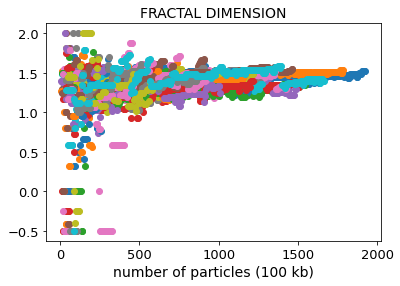

In [6]:
save_data= True
window=15
polynomial=2
thresh=np.zeros(len(files_xls))

plt.figure()
for t in range(len(files_xls)):
    xls=pd.ExcelFile('{}/{}'.format(path,files_xls[t]))
    df = pd.read_excel(xls)
    FractDim=df['Fractal dimension']
    atoms=df['n atoms']
    len_FractDim=len(FractDim)
    atoms_FractDim=atoms[len(atoms)-len_FractDim:len(atoms)]
    if (chr_vec[t]==chosen_chr):
        FractDim_select=FractDim
        atoms_select= atoms_FractDim   

    std=np.std(FractDim)
    for x in range(len_FractDim):
        if (FractDim[x]<np.mean(FractDim)-std or FractDim[x]>np.mean(FractDim)+std):
            thresh[t]=atoms_FractDim[x]
            
    plt.title('FRACTAL DIMENSION')
    plt.scatter(atoms_FractDim, FractDim)
    plt.xlabel('number of particles (100 kb)')
    
    
if save_data:
    cell_vector=[cell]*len(FractDim_select)
    Fractdim_select_cell={'atoms':atoms_select, 'Fractal dimension':FractDim_select,'cell':cell_vector }
    Fractdim_select_cell=pd.DataFrame(Fractdim_select_cell)
    Fractdim_select_cell.to_csv('{}/df_fractdim_{}.csv'.format(path_results,chosen_chr))
    
    cell_vector=[cell]*len(thresh)
    thresh_FractDim = {'threshold': thresh, 'cell': cell_vector}
    thresh_FractDim = pd.DataFrame(thresh_FractDim)
    thresh_FractDim.to_csv('{}/df_fractThreshold.csv'.format(path_results))

Combine data from single cells into one dataframe, for the chosen chromosome

In [8]:
letters=list(string.ascii_lowercase)
chr_vec=['chr {}'.format(letter) for letter in letters[:n_all_chr]]
cells=['cell{}'.format(num) for num in np.arange(1,9,1)]
high_clust = ['cell1', 'cell4', 'cell6', 'cell8']
low_clust = ['cell2', 'cell3', 'cell5', 'cell7']

FractDim_allcells=pd.DataFrame()

for cell in cells:
    path='results/cumulative analysis/{}'.format(cell)
    df_single=pd.read_csv('{}/df_fractdim_{}.csv'.format(path,chosen_chr))
    
    if cell in high_clust:
        clustering = ['High clustering']*len(df_single)
        df_single['Clustering']=clustering
    else:
        clustering = ['Low clustering']*len(df_single)
        df_single['Clustering']=clustering
        
    frames=[FractDim_allcells, df_single]
    FractDim_allcells=pd.concat(frames)
    
    
FractDim_allcells.dropna(subset = ["Fractal dimension"],inplace=True)

Plot comparison fractal dimension for one chromosome in the high and low clustering group

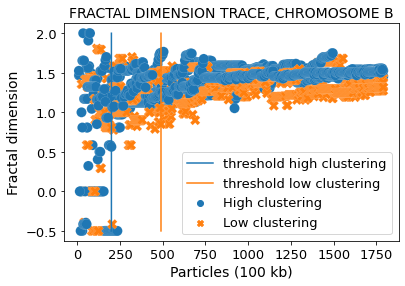

In [79]:
FractDim_high=np.array(FractDim_allcells['Fractal dimension'][FractDim_allcells['Clustering']=='High clustering'])
atoms_high=np.array(FractDim_allcells['atoms'][FractDim_allcells['Clustering']=='High clustering'])
FractDim_low=np.array(FractDim_allcells['Fractal dimension'][FractDim_allcells['Clustering']=='Low clustering'])
atoms_low=np.array(FractDim_allcells['atoms'][FractDim_allcells['Clustering']=='Low clustering'])

thresh_high=convergence_threshold(FractDim_high, atoms_high)
thresh_low=convergence_threshold(FractDim_low, atoms_low)


save_fig= False
line_x_high,line_y_high=plot_vertical_line(thresh_high,FractDim_high)
line_x_low,line_y_low=plot_vertical_line(thresh_low,FractDim_low)

fig=plt.figure()
sns.scatterplot(data=FractDim_allcells, x='atoms',y='Fractal dimension', hue='Clustering', 
                style="Clustering", s=100 ,linewidth=0.1)
plt.plot(line_x_high,line_y_high, label= 'threshold high clustering')
plt.plot(line_x_low,line_y_low, label= 'threshold low clustering')
plt.title('FRACTAL DIMENSION TRACE, CHROMOSOME {}'.format(chosen_chr[-1].upper()))
plt.legend()
plt.xlabel('Particles (100 kb)')

if save_fig:
    save_figures(fig, path='results/cumulative analysis', name_file= 'fractdim_{}'.format(chosen_chr))

Plot threshold for all cells, divided into high and low clustering group

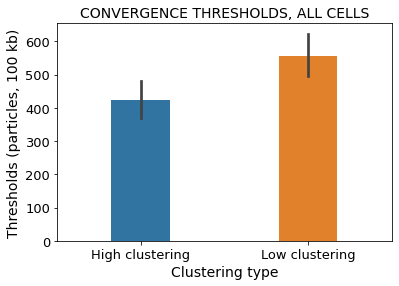

In [46]:
save_fig=True
thresholds_df=pd.DataFrame()

for cell in cells:
    thresholds = pd.read_csv('results/cumulative analysis/{}/df_fractThreshold.csv'.format(cell))
    
    if cell in high_clust:
        thresholds['Clustering']= ['High clustering']*len(thresholds)
    else:
        thresholds['Clustering']= ['Low clustering']*len(thresholds)
        
    frames=[thresholds_df, thresholds]
    thresholds_df=pd.concat(frames)

    
fig, ax = plt.subplots()
sns.barplot(x='Clustering', y='threshold', data=thresholds_df, ax=ax)
change_width(ax, .35)
plt.xlabel('Clustering type')
plt.ylabel('Thresholds (particles, 100 kb)')
plt.title('CONVERGENCE THRESHOLDS, ALL CELLS')

if save_fig:
    save_figures(fig, path='results/cumulative analysis', name_file='thresholds_allcells')